In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# import plotly.offline as py
# import plotly.graph_objs as go
import numpy as np
import seaborn as sns
# py.init_notebook_mode(connected=True)
# %matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

sns.set(font='SimHei',font_scale=1.5)  # 解决Seaborn中文显示问题并调整字体大小

In [3]:
#导入数据
df = pd.read_csv("newdata3.csv")
df["订单日期"]=df["订单日期"].apply(pd.to_datetime,format='%Y-%m-%d')
df

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,年,月,日,是否促销日,季节,星期,是否工作日,上中下旬,是否节假日
0,2015-09-01,104,22069,307,403,1,1114.0,19,2015,9,1,0,3,2,1,1,0
1,2015-09-01,104,20028,301,405,1,1012.0,12,2015,9,1,0,3,2,1,1,0
2,2015-09-02,104,21183,307,403,0,428.0,109,2015,9,2,0,3,3,1,1,0
3,2015-09-02,104,20448,308,404,0,962.0,3,2015,9,2,0,3,3,1,1,0
4,2015-09-02,104,21565,307,403,1,1400.0,3,2015,9,2,0,3,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597377,2018-12-20,102,20994,302,408,1,843.0,59,2018,12,20,0,4,4,1,2,0
597378,2018-12-20,102,21875,302,408,1,762.0,502,2018,12,20,0,4,4,1,2,0
597379,2018-12-20,102,20215,302,408,1,2013.0,106,2018,12,20,0,4,4,1,2,0
597380,2018-12-20,102,20195,302,408,1,2120.0,187,2018,12,20,0,4,4,1,2,0


In [4]:
#将订单日期作为索引
df = df.set_index('订单日期')
df

,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量,年,月,日,是否促销日,季节,星期,是否工作日,上中下旬,是否节假日
订单日期,,,,,,,,,,,,,,,,
2015-09-01,104,22069,307,403,1,1114.0,19,2015,9,1,0,3,2,1,1,0
2015-09-01,104,20028,301,405,1,1012.0,12,2015,9,1,0,3,2,1,1,0
2015-09-02,104,21183,307,403,0,428.0,109,2015,9,2,0,3,3,1,1,0
2015-09-02,104,20448,308,404,0,962.0,3,2015,9,2,0,3,3,1,1,0
2015-09-02,104,21565,307,403,1,1400.0,3,2015,9,2,0,3,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-20,102,20994,302,408,1,843.0,59,2018,12,20,0,4,4,1,2,0
2018-12-20,102,21875,302,408,1,762.0,502,2018,12,20,0,4,4,1,2,0
2018-12-20,102,20215,302,408,1,2013.0,106,2018,12,20,0,4,4,1,2,0


In [5]:
#提取训练列项
df_train = df[['销售区域编码', '产品大类编码','产品细类编码','产品编码','订单需求量']]
df_train

,销售区域编码,产品大类编码,产品细类编码,产品编码,订单需求量
订单日期,,,,,
2015-09-01,104,307,403,22069,19
2015-09-01,104,301,405,20028,12
2015-09-02,104,307,403,21183,109
2015-09-02,104,308,404,20448,3
2015-09-02,104,307,403,21565,3
...,...,...,...,...,...
2018-12-20,102,302,408,20994,59
2018-12-20,102,302,408,21875,502
2018-12-20,102,302,408,20215,106


In [6]:
#导入待预测数据
pre = pd.read_csv("predict_sku1.csv")
pre.columns=['销售区域编码','产品编码','产品大类编码','产品细类编码']
data_pre = pd.DataFrame(pre,columns=['销售区域编码', '产品大类编码', '产品细类编码','产品编码'])
pre

,销售区域编码,产品编码,产品大类编码,产品细类编码
0,101,20002,303,406
1,101,20003,301,405
2,101,20006,307,403
3,101,20011,303,401
4,101,20014,307,403
...,...,...,...,...
2614,105,22066,307,403
2615,105,22072,305,412
2616,105,22075,307,403
2617,105,22083,303,401


In [7]:
#以20002号商品为例，提取出20002号商品
data_pre.loc[data_pre['产品编码'] == 20002]

,销售区域编码,产品大类编码,产品细类编码,产品编码
0,101,303,406,20002
654,102,303,406,20002
1290,103,303,406,20002
1930,105,303,406,20002


In [8]:
#从训练数据中提取20002号商品
df_train_20002 = df_train.loc[(df_train['产品编码'] == 20002)&(df_train['销售区域编码'] == 101)&(df_train['产品大类编码'] == 303)&(df_train['产品细类编码'] == 406)]
df_train_20002

,销售区域编码,产品大类编码,产品细类编码,产品编码,订单需求量
订单日期,,,,,
2017-08-04,101,303,406,20002,4
2018-03-14,101,303,406,20002,2
2018-03-16,101,303,406,20002,3
2018-03-25,101,303,406,20002,3
2018-03-31,101,303,406,20002,9
...,...,...,...,...,...
2018-11-30,101,303,406,20002,9
2018-12-13,101,303,406,20002,18
2018-12-14,101,303,406,20002,24


In [9]:
#补全时间序列数据
df_train_20002_byday = df_train_20002.groupby([ pd.Grouper( freq='d')])['订单需求量'].mean().reset_index()
df_train_20002_byday.set_index('订单日期',inplace = True)
df_train_20002_byday=df_train_20002_byday.fillna(method='ffill')
df_train_20002_byday

,订单需求量
订单日期,
2017-08-04,4.0
2017-08-05,4.0
2017-08-06,4.0
2017-08-07,4.0
2017-08-08,4.0
...,...
2018-12-16,24.0
2018-12-17,24.0
2018-12-18,24.0


<AxesSubplot:xlabel='订单日期', ylabel='订单需求量'>

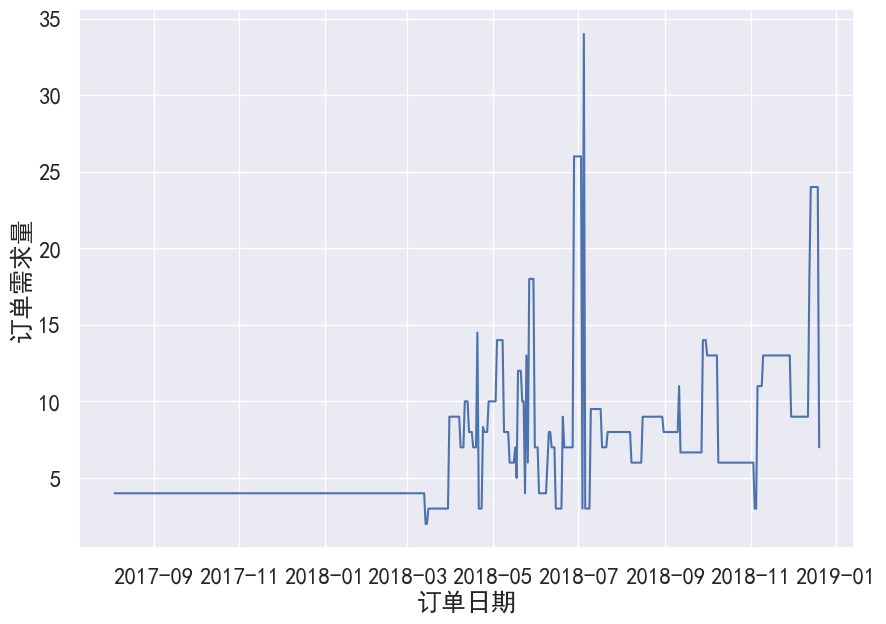

In [10]:
plt.figure(figsize=(10,7))
# plt.title("")
# plt.scatter(x=df_train_20002.index, y=df_train_20002['ord_qty'])
sns.lineplot(x='订单日期', y='订单需求量',  data=df_train_20002_byday)

In [11]:
#将数据归一化到0-1范围之内，加速模型收敛
from sklearn.preprocessing import MinMaxScaler
values = df_train_20002_byday['订单需求量'].values.reshape(-1,1)#提取订单需求量
values = values.astype('float32')#转换数据类型
scaler = MinMaxScaler(feature_range=(0, 1))#归一化到0-1之间
scaled = scaler.fit_transform(values)#归一化
train_size = int(len(scaled) * 0.9)#训练集长度
test_size = len(scaled) - train_size#测试集长度
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]#构造训练集和测试集
print(len(train), len(test))

453 51


In [12]:
#创建时间序列数据集
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [13]:
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
print(trainY.shape)

448
46
(448, 5)
(448,)


In [14]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)
print(testX.shape)

(448, 1, 5)
(46, 1, 5)


In [15]:
model = Sequential()#创建模型
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))#添加一个 LSTM 层。LSTM 层的单元数为 100
model.add(Dense(1))#在模型中添加一个全连接层。用于输出预测值。
model.compile(loss='mse', optimizer='adam')#损失函数为mes，参数指定优化器为 adam，用于更新模型的权重以最小化损失函数。
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

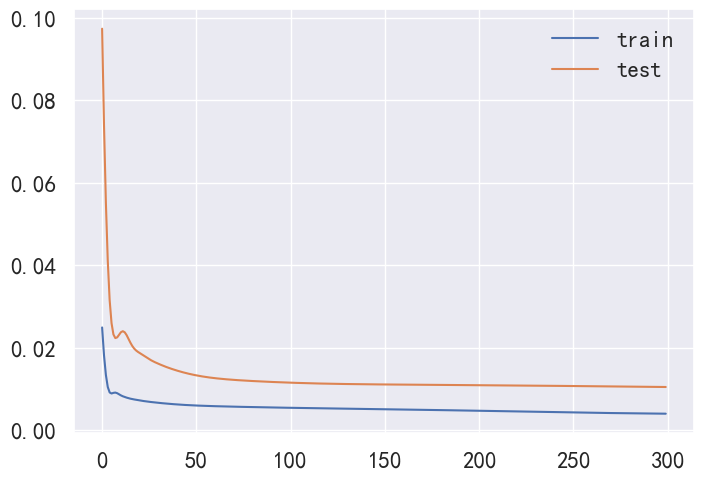

In [16]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

2/2 [==============================] - 0s 0s/step


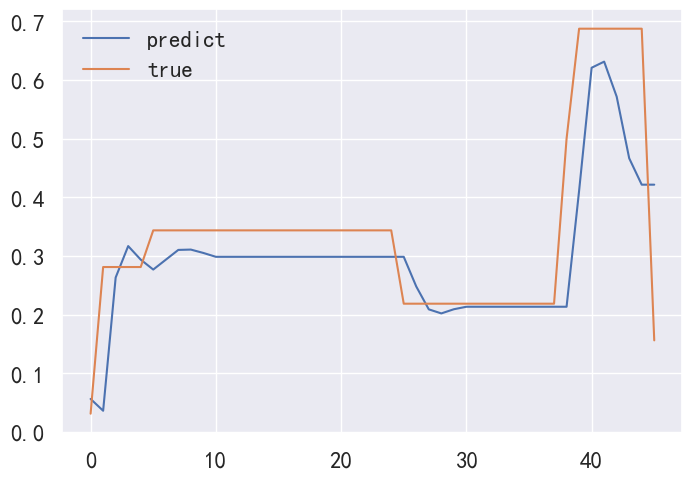

In [17]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [18]:
#进行反归一化，计算rmse
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.271


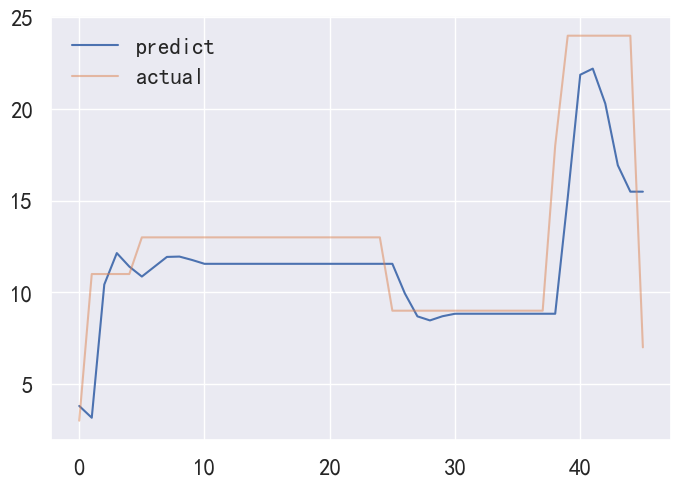

In [19]:
#绘制反归一化后的图像
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [20]:
#提取和textX长度相等的后几个日期
predictDates = df_train_20002_byday.tail(len(testX)).index
predictDates

DatetimeIndex(['2018-11-05', '2018-11-06', '2018-11-07', '2018-11-08',
               '2018-11-09', '2018-11-10', '2018-11-11', '2018-11-12',
               '2018-11-13', '2018-11-14', '2018-11-15', '2018-11-16',
               '2018-11-17', '2018-11-18', '2018-11-19', '2018-11-20',
               '2018-11-21', '2018-11-22', '2018-11-23', '2018-11-24',
               '2018-11-25', '2018-11-26', '2018-11-27', '2018-11-28',
               '2018-11-29', '2018-11-30', '2018-12-01', '2018-12-02',
               '2018-12-03', '2018-12-04', '2018-12-05', '2018-12-06',
               '2018-12-07', '2018-12-08', '2018-12-09', '2018-12-10',
               '2018-12-11', '2018-12-12', '2018-12-13', '2018-12-14',
               '2018-12-15', '2018-12-16', '2018-12-17', '2018-12-18',
               '2018-12-19', '2018-12-20'],
              dtype='datetime64[ns]', name='订单日期', freq=None)

In [21]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

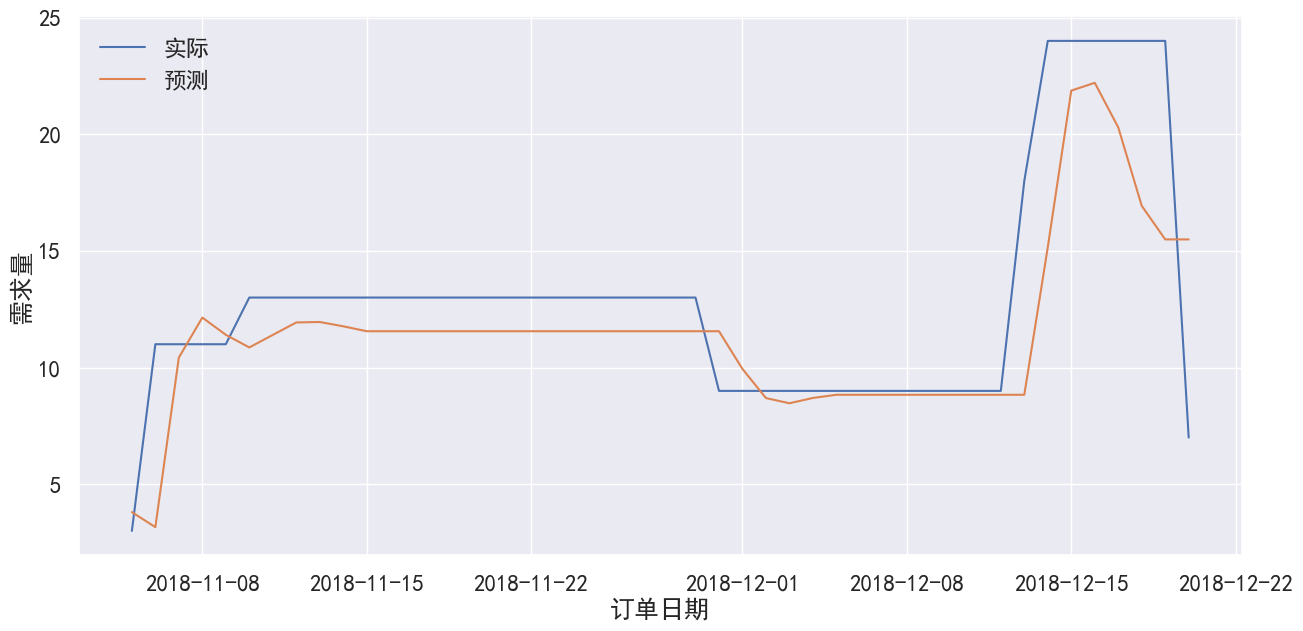

In [22]:
#绘图
plt.figure(figsize=(15,7))
actual_chart = sns.lineplot(x=predictDates, y=testY_reshape,label='实际')
predict_chart = sns.lineplot(x=predictDates, y=yhat_reshape,label='预测')
plt.ylabel('需求量')
plt.legend()

1/1 [==============================] - 0s 18ms/step


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1/1 [==============================] - 0s 31ms/step


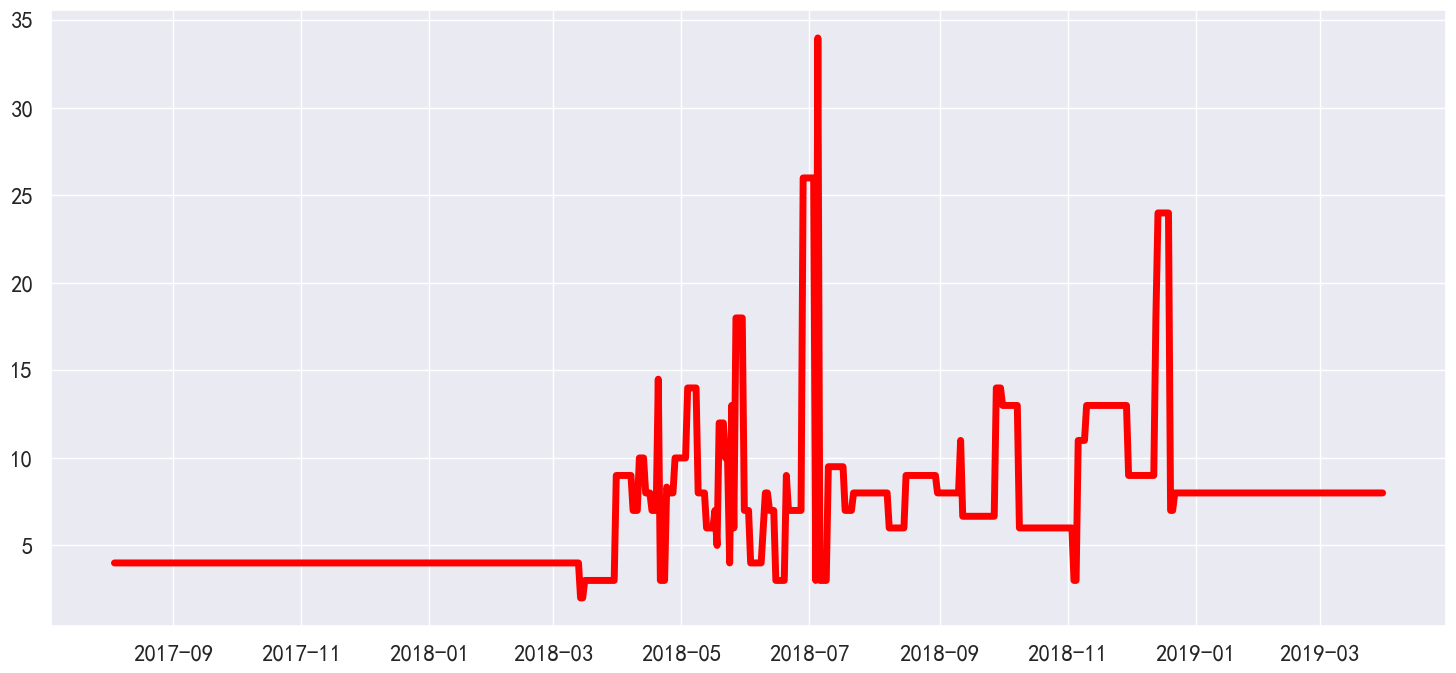

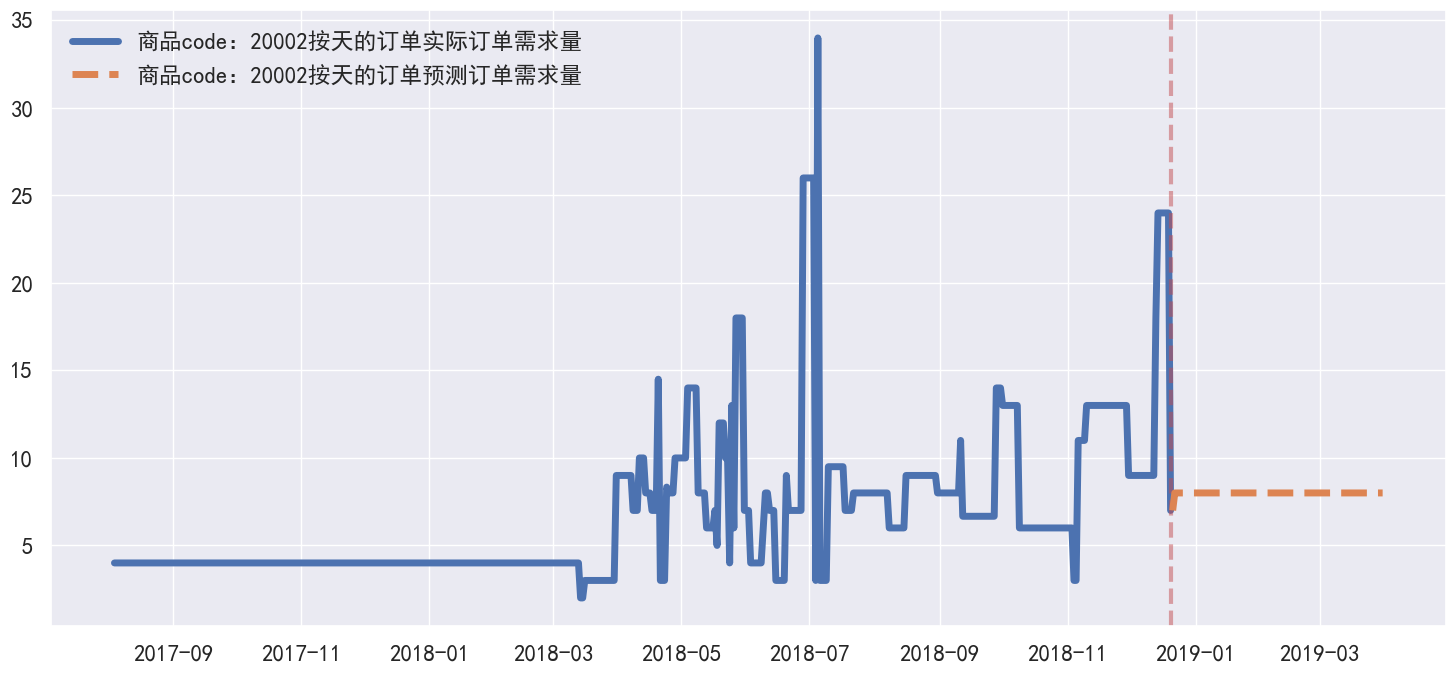

In [23]:
df_30_days_past=df_train_20002_byday.iloc[-100:-90,:]#-5:,:   -100:-90,:
data_pre_exm = data_pre.loc[data_pre['产品编码'] == 20002][0:1]
data_pre_new = pd.DataFrame(np.repeat(data_pre_exm.values,101,axis=0))
data_pre_new.columns = data_pre_exm.columns
data_pre_new["订单需求量"]=0
df_90_days_future=data_pre_new[["订单需求量"]]

old_scaled_array=scaler.transform(df_30_days_past)
new_scaled_array=scaler.transform(df_90_days_future)
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,0]=np.nan
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

full_df_scaled_array=full_df.values
all_data=[]
time_step=5
for i in range(time_step,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(
    full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]].reshape(1,5))
    data_x=np.array(data_x)
    prediction=model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction

date = pd.date_range('2018-12-21', '2019-03-31',freq='D')
future = pd.DataFrame(index=date, columns= df_train_20002_byday.columns)
future['订单需求量'] = np.rint(scaler.inverse_transform(full_df.values)[10::])
df_alldata = pd.concat([df_train_20002_byday, future])

plt.figure(figsize=(18, 8))
plt.plot(df_alldata['订单需求量'], label='商品code：20002按天的订单需求', color='red', linestyle='-',linewidth = '5')

def predict_plot(df,data,label):
    plt.figure(figsize=(18, 8))
    plt.plot(df.loc[:,label], label='商品code：20002按天的订单'+'实际'+label,linestyle='-',linewidth = '5')
    plt.axvline(x=df.index[-1], alpha=0.5, c="r", ls="--", lw=3)
    # plt.plot(test['count'], label='Test')
    plt.plot(data[label], label='商品code：20002按天的订单'+'预测'+label,linestyle='--',linewidth = '5')
    plt.legend(loc='best')
    plt.show()

predict_plot(df_train_20002_byday,future,'订单需求量')

In [24]:
df_alldata.reset_index(inplace=True)
df_alldata.columns=['订单日期','订单需求量']
df_alldata['月'] = df_alldata['订单日期'].dt.month
final_pre=df_alldata[df_alldata['订单日期']>='2019-1-1']
grouped_data=final_pre.groupby('月')['订单需求量'].sum()
demand_data = grouped_data.values.astype(str).T

# 定义要写入的文件路径
file_path = '订单需求量1.txt'

# 以追加方式打开文件，并写入需求量数据
with open(file_path, 'a') as file:
    for demand in demand_data:
        file.write(demand+" ")
    file.write('\n')

In [ ]:
look_back = 10
for i in range(data_pre.shape[0]):
    predict1=data_pre.iloc[i]
    data_training1=df[(df['产品大类编码']== predict1['产品大类编码'])&(df['产品细类编码']== predict1['产品细类编码'])&(df['产品编码']== predict1['产品编码'])&(df['销售区域编码']== predict1['销售区域编码'])]
    data_training2=df[(df['产品大类编码']== predict1['产品大类编码'])&(df['产品细类编码']== predict1['产品细类编码'])&(df['产品编码']== predict1['产品编码'])]
    data_training3=df[(df['产品大类编码']== predict1['产品大类编码'])&(df['产品细类编码']== predict1['产品细类编码'])&(df['销售区域编码']== predict1['销售区域编码'])]
    
    data_training=data_training1[['产品大类编码','产品细类编码','产品编码','销售区域编码','订单需求量']]
    if data_training.shape[0]==0:
        data_training=data_training2[['产品大类编码','产品细类编码','产品编码','销售区域编码','订单需求量']]
    if data_training.shape[0]==0:
        data_training=data_training3[['产品大类编码','产品细类编码','产品编码','销售区域编码','订单需求量']]
    df_train_byday = data_training.groupby([ pd.Grouper( freq='D')])['订单需求量'].mean().reset_index()
    df_train_byday.set_index('订单日期',inplace = True)
    df_train_byday=df_train_byday.fillna(method='ffill')
    
    values = df_train_byday['订单需求量'].values.reshape(-1,1)#提取订单需求量
    values = values.astype('float32')#转换数据类型
    scaler = MinMaxScaler(feature_range=(0, 1))#归一化到0-1之间
    scaled = scaler.fit_transform(values)#归一化
    train_size = int(len(scaled) * 0.9)#训练集长度
    test_size = len(scaled) - train_size#测试集长度
    train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]#构造训练集和测试集
    

    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    try:
        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    except Exception as e:
        print("错误信息:",e)
        continue
    
    model = Sequential()#创建一个序贯模型对象
    model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))#在模型中添加一个 LSTM 层。这里的参数为 100，表示 LSTM 层的单元数
    model.add(Dense(1))#在模型中添加一个全连接（密集）层。这个层只有一个神经元，用于输出预测值。
    model.compile(loss='mse', optimizer='adam')#损失函数为mes，参数指定优化器为 adam，用于更新模型的权重以最小化损失函数。
    history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)
    
    yhat = model.predict(testX)
    yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
    testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
    rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
    print(i)
    print('Test RMSE: %.3f' % rmse)
    
    predictDates = df_train_byday.tail(len(testX)).index
    testY_reshape = testY_inverse.reshape(len(testY_inverse))
    yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))
    
    df_30_days_past=df_train_byday.iloc[-100:-90,:]
    data_pre_exm = data_pre.loc[data_pre['产品编码'] == predict1['产品编码']][0:1]
    data_pre_new = pd.DataFrame(np.repeat(data_pre_exm.values,101,axis=0))
    data_pre_new.columns = data_pre_exm.columns
    data_pre_new["订单需求量"]=0
    df_90_days_future=data_pre_new[["订单需求量"]]
    
    old_scaled_array=scaler.transform(df_30_days_past)
    new_scaled_array=scaler.transform(df_90_days_future)
    new_scaled_df=pd.DataFrame(new_scaled_array)
    new_scaled_df.iloc[:,0]=np.nan
    full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)
    
    full_df_scaled_array=full_df.values
    all_data=[]
    time_step=10
    for i in range(time_step,len(full_df_scaled_array)):
        data_x=[]
        data_x.append(
        full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]].reshape(1,10))
        data_x=np.array(data_x)
        prediction=model.predict(data_x,verbose=0)
        all_data.append(prediction)
        full_df.iloc[i,0]=prediction
    date = pd.date_range('2018-12-21', '2019-03-31',freq='D')
    future = pd.DataFrame(index=date, columns= df_train_byday.columns)
    future['订单需求量'] = np.rint(scaler.inverse_transform(full_df.values)[10::])
    df_alldata = pd.concat([df_train_byday, future])
    df_alldata.reset_index(inplace=True)
    df_alldata.columns=['订单日期','订单需求量']
    df_alldata['月'] = df_alldata['订单日期'].dt.month
    final_pre=df_alldata[df_alldata['订单日期']>='2019-1-1']
    grouped_data=final_pre.groupby('月')['订单需求量'].sum()
    demand_data = grouped_data.values.astype(str).T
   

# 定义要写入的文件路径
    file_path = '订单需求量.txt'

# 以追加方式打开文件，并写入需求量数据
    with open(file_path, 'a') as file:
        for demand in demand_data:
            file.write(demand+" ")
        file.write('\n')

443
41
2/2 [==============================] - 0s 0s/step
0
Test RMSE: 3.756


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


635
62
2/2 [==============================] - 0s 5ms/step
1
Test RMSE: 40.728


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


619
60
2/2 [==============================] - 0s 0s/step
2
Test RMSE: 18.890


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1072
111
4/4 [==============================] - 1s 5ms/step
3
Test RMSE: 36.975


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


521
49
2/2 [==============================] - 0s 16ms/step
4
Test RMSE: 19.581


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


680
67
3/3 [==============================] - 0s 2ms/step
5
Test RMSE: 34.312


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


329
28
1/1 [==============================] - 1s 583ms/step
6
Test RMSE: 59.467


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1072
111
4/4 [==============================] - 0s 7ms/step
7
Test RMSE: 0.296


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


611
60
2/2 [==============================] - 0s 16ms/step
8
Test RMSE: 3.343


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


270
22
1/1 [==============================] - 0s 364ms/step
9
Test RMSE: 42.017


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


0
0
错误信息: tuple index out of range
320
27
1/1 [==============================] - 0s 367ms/step
11
Test RMSE: 93.440


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


3
0
错误信息: tuple index out of range
519
49
2/2 [==============================] - 0s 0s/step
13
Test RMSE: 3.764


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


21
0
错误信息: tuple index out of range
602
58
2/2 [==============================] - 0s 16ms/step
15
Test RMSE: 20.298


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


846
86
3/3 [==============================] - 0s 4ms/step
16
Test RMSE: 5.424


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


513
49
2/2 [==============================] - 0s 0s/step
17
Test RMSE: 11.977


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


917
94
3/3 [==============================] - 0s 6ms/step
18
Test RMSE: 9.307


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


637
62
2/2 [==============================] - 0s 0s/step
19
Test RMSE: 42.635


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


615
60
2/2 [==============================] - 0s 0s/step
20
Test RMSE: 12.021


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


70
0
错误信息: tuple index out of range
268
21
1/1 [==============================] - 0s 388ms/step
22
Test RMSE: 126.847


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


597
58
2/2 [==============================] - 0s 0s/step
23
Test RMSE: 37.545


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


63
0
错误信息: tuple index out of range
169
10
1/1 [==============================] - 0s 436ms/step
25
Test RMSE: 119.381


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1073
111
4/4 [==============================] - 0s 0s/step
26
Test RMSE: 47.977


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


791
80
3/3 [==============================] - 0s 0s/step
27
Test RMSE: 5.882


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


493
46
2/2 [==============================] - 0s 0s/step
28
Test RMSE: 10.841


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


262
21
1/1 [==============================] - 0s 361ms/step
29
Test RMSE: 4.160


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


277
22
1/1 [==============================] - 0s 440ms/step
30
Test RMSE: 4.985


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


297
25
1/1 [==============================] - 0s 424ms/step
31
Test RMSE: 4.096


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


997
102
4/4 [==============================] - 1s 0s/step
32
Test RMSE: 8.439


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1001
103
4/4 [==============================] - 0s 3ms/step
33
Test RMSE: 4.739


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


998
103
4/4 [==============================] - 1s 0s/step
34
Test RMSE: 21.295


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1066
110
4/4 [==============================] - 0s 5ms/step
35
Test RMSE: 5.897


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


0
0
错误信息: tuple index out of range
195
13
1/1 [==============================] - 0s 423ms/step
37
Test RMSE: 5.894


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


33
0
错误信息: tuple index out of range
0
0
错误信息: tuple index out of range
958
98
4/4 [==============================] - 1s 3ms/step
40
Test RMSE: 17.034


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1014
104
4/4 [==============================] - 0s 2ms/step
41
Test RMSE: 306.600


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


33
0
错误信息: tuple index out of range
602
58
2/2 [==============================] - 0s 0s/step
43
Test RMSE: 10.771


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


0
0
错误信息: tuple index out of range
299
25
1/1 [==============================] - 0s 425ms/step
45
Test RMSE: 13.475


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


35
0
错误信息: tuple index out of range
183
12
1/1 [==============================] - 0s 412ms/step
47
Test RMSE: 1.406


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1073
111
4/4 [==============================] - 0s 2ms/step
48
Test RMSE: 55.335


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


249
19
1/1 [==============================] - 0s 408ms/step
49
Test RMSE: 3.031


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


398
36
2/2 [==============================] - 0s 0s/step
50
Test RMSE: 3.575


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


692
69
3/3 [==============================] - 0s 5ms/step
51
Test RMSE: 5.186


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


421
38
2/2 [==============================] - 0s 2ms/step
52
Test RMSE: 69.400


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


107
4
1/1 [==============================] - 0s 376ms/step
53
Test RMSE: 16.235


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


160
9
1/1 [==============================] - 0s 468ms/step
54
Test RMSE: 22.092


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


255
20
1/1 [==============================] - 0s 373ms/step
55
Test RMSE: 19.412


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1073
111
4/4 [==============================] - 0s 5ms/step
56
Test RMSE: 55.026


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


581
56
2/2 [==============================] - 0s 0s/step
57
Test RMSE: 27.582


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


503
47
2/2 [==============================] - 0s 16ms/step
58
Test RMSE: 9.861


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


25
0
错误信息: tuple index out of range
1072
111
4/4 [==============================] - 0s 3ms/step
60
Test RMSE: 36.925


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


826
83
3/3 [==============================] - 0s 3ms/step
61
Test RMSE: 125.356


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


23
0
错误信息: tuple index out of range
75
0
错误信息: tuple index out of range
314
27
1/1 [==============================] - 0s 397ms/step
64
Test RMSE: 25.998


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


564
54
2/2 [==============================] - 1s 0s/step
65
Test RMSE: 107.701


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1068
110
4/4 [==============================] - 0s 6ms/step
66
Test RMSE: 11.835


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


636
62
2/2 [==============================] - 0s 0s/step
67
Test RMSE: 46.611


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1065
110
4/4 [==============================] - 0s 2ms/step
68
Test RMSE: 1.124


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


0
0
错误信息: tuple index out of range
171
11
1/1 [==============================] - 0s 345ms/step
70
Test RMSE: 1.897


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


0
0
错误信息: tuple index out of range
206
14
1/1 [==============================] - 0s 423ms/step
72
Test RMSE: 3.359


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


665
66
3/3 [==============================] - 0s 3ms/step
73
Test RMSE: 0.665


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1025
106
4/4 [==============================] - 0s 4ms/step
74
Test RMSE: 54.224


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


244
19
1/1 [==============================] - 0s 453ms/step
75
Test RMSE: 1.741


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


440
40
2/2 [==============================] - 0s 0s/step
76
Test RMSE: 67.251


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


209
15
1/1 [==============================] - 0s 387ms/step
77
Test RMSE: 312.048


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1072
111
4/4 [==============================] - 0s 2ms/step
78
Test RMSE: 36.928


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1
0
错误信息: tuple index out of range
177
11
1/1 [==============================] - 0s 437ms/step
80
Test RMSE: 1.926


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


84
1
1/1 [==============================] - 0s 401ms/step
81
Test RMSE: 3.990


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


376
33
2/2 [==============================] - 0s 0s/step
82
Test RMSE: 2.151


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


291
24
1/1 [==============================] - 0s 406ms/step
83
Test RMSE: 40.865


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


69
0
错误信息: tuple index out of range
0
0
错误信息: tuple index out of range
1072
111
4/4 [==============================] - 0s 5ms/step
86
Test RMSE: 74.984


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


26
0
错误信息: tuple index out of range
1052
108
4/4 [==============================] - 0s 6ms/step
88
Test RMSE: 3.160


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1073
111
4/4 [==============================] - 0s 3ms/step
89
Test RMSE: 47.818


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


66
0
错误信息: tuple index out of range
776
78
3/3 [==============================] - 0s 3ms/step
91
Test RMSE: 114.346


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


194
13
1/1 [==============================] - 0s 419ms/step
92
Test RMSE: 4.263


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


963
99
4/4 [==============================] - 1s 3ms/step
93
Test RMSE: 13.651


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


246
19
1/1 [==============================] - 0s 429ms/step
94
Test RMSE: 2.820


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


826
83
3/3 [==============================] - 0s 3ms/step
95
Test RMSE: 43.911


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


624
61
2/2 [==============================] - 0s 0s/step
96
Test RMSE: 2.752


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


66
0
错误信息: tuple index out of range
93
2
1/1 [==============================] - 0s 392ms/step
98
Test RMSE: 12.964


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1070
110
4/4 [==============================] - 0s 6ms/step
99
Test RMSE: 177.284


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1072
111
4/4 [==============================] - 0s 3ms/step
100
Test RMSE: 36.931


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


183
12
1/1 [==============================] - 0s 389ms/step
101
Test RMSE: 4.212


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1044
108
4/4 [==============================] - 0s 2ms/step
102
Test RMSE: 0.863


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


410
37
2/2 [==============================] - 0s 0s/step
103
Test RMSE: 2.028


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


637
62
2/2 [==============================] - 0s 16ms/step
104
Test RMSE: 42.613


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2
0
错误信息: tuple index out of range
134
6
1/1 [==============================] - 0s 377ms/step
106
Test RMSE: 17.378


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


534
51
2/2 [==============================] - 1s 14ms/step
107
Test RMSE: 50.265


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


958
98
4/4 [==============================] - 0s 7ms/step
108
Test RMSE: 102.083


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


146
8
1/1 [==============================] - 0s 435ms/step
109
Test RMSE: 154.917


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


58
0
错误信息: tuple index out of range
64
0
错误信息: tuple index out of range
0
0
错误信息: tuple index out of range
117
5
1/1 [==============================] - 0s 392ms/step
113
Test RMSE: 32.851


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


637
62
2/2 [==============================] - 0s 0s/step
114
Test RMSE: 42.720


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


429
39
2/2 [==============================] - 0s 0s/step
115
Test RMSE: 3.472


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1073
111
4/4 [==============================] - 0s 3ms/step
116
Test RMSE: 55.060


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


733
73
3/3 [==============================] - 0s 7ms/step
117
Test RMSE: 0.814


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


109
4
1/1 [==============================] - 0s 389ms/step
118
Test RMSE: 8.330


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1043
108
4/4 [==============================] - 0s 4ms/step
119
Test RMSE: 78.574


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


137
7
1/1 [==============================] - 0s 357ms/step
120
Test RMSE: 153.168


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


172
11
1/1 [==============================] - 0s 420ms/step
121
Test RMSE: 4.146


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


108
4
1/1 [==============================] - 0s 362ms/step
122
Test RMSE: 4.213


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


798
80
3/3 [==============================] - 0s 8ms/step
123
Test RMSE: 0.562


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


526
50
2/2 [==============================] - 0s 0s/step
124
Test RMSE: 31.116


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


354
31
1/1 [==============================] - 0s 392ms/step
125
Test RMSE: 70.121


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


176
11
1/1 [==============================] - 0s 401ms/step
126
Test RMSE: 1.195


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


826
83
3/3 [==============================] - 0s 504us/step
127
Test RMSE: 54.180


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


637
62
2/2 [==============================] - 0s 16ms/step
128
Test RMSE: 305.950


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


652
64
2/2 [==============================] - 0s 0s/step
129
Test RMSE: 1.266


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


641
63
2/2 [==============================] - 0s 0s/step
130
Test RMSE: 7.765


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


228
17
1/1 [==============================] - 0s 408ms/step
131
Test RMSE: 12.482


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


91
2
1/1 [==============================] - 1s 526ms/step
132
Test RMSE: 25.220


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1061
110
4/4 [==============================] - 1s 5ms/step
133
Test RMSE: 43.892


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


637
62
2/2 [==============================] - 0s 0s/step
134
Test RMSE: 67.791


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


471
44
2/2 [==============================] - 0s 0s/step
135
Test RMSE: 14.137


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


125
5
1/1 [==============================] - 1s 596ms/step
136
Test RMSE: 33.568


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


295
24
1/1 [==============================] - 0s 345ms/step
137
Test RMSE: 40.187


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


435
40
2/2 [==============================] - 0s 0s/step
138
Test RMSE: 1.986


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


319
27
1/1 [==============================] - 0s 376ms/step
139
Test RMSE: 12.835


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


208
15
1/1 [==============================] - 1s 691ms/step
140
Test RMSE: 129.841


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


161
9
1/1 [==============================] - 0s 392ms/step
141
Test RMSE: 188.238


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1055
109
4/4 [==============================] - 0s 5ms/step
142
Test RMSE: 18.431


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


309
26
1/1 [==============================] - 1s 534ms/step
143
Test RMSE: 23.476


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


46
0
错误信息: tuple index out of range
89
2
1/1 [==============================] - 0s 361ms/step
145
Test RMSE: 3.026


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1062
110
4/4 [==============================] - 1s 5ms/step
146
Test RMSE: 11.483


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


84
1
1/1 [==============================] - 0s 426ms/step
147
Test RMSE: 11.994


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1073
111
4/4 [==============================] - 0s 5ms/step
148
Test RMSE: 47.908


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


234
18
1/1 [==============================] - 0s 409ms/step
149
Test RMSE: 3.499


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1068
110
4/4 [==============================] - 0s 0s/step
150
Test RMSE: 114.403


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1072
111
4/4 [==============================] - 0s 1ms/step
151
Test RMSE: 2.917


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


207
15
1/1 [==============================] - 0s 439ms/step
152
Test RMSE: 1.667


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


436
40
2/2 [==============================] - 0s 0s/step
153
Test RMSE: 4.297


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


156
9
1/1 [==============================] - 0s 408ms/step
154
Test RMSE: 48.594


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


98
3
1/1 [==============================] - 0s 377ms/step
155
Test RMSE: 16.307


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


375
33
2/2 [==============================] - 0s 0s/step
156
Test RMSE: 16.703


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1068
110
4/4 [==============================] - 1s 0s/step
157
Test RMSE: 13.371


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


623
61
2/2 [==============================] - 0s 0s/step
158
Test RMSE: 68.287


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


122
5
1/1 [==============================] - 0s 439ms/step
159
Test RMSE: 3.721


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


851
86
3/3 [==============================] - 0s 0s/step
160
Test RMSE: 1.043


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


631
62
2/2 [==============================] - 0s 0s/step
161
Test RMSE: 71.812


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1021
105
4/4 [==============================] - 0s 4ms/step
162
Test RMSE: 1.125


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


637
62
2/2 [==============================] - 0s 0s/step
163
Test RMSE: 42.618


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


634
62
2/2 [==============================] - 0s 0s/step
164
Test RMSE: 168.147


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


311
26
1/1 [==============================] - 0s 471ms/step
165
Test RMSE: 13.991


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


512
48
2/2 [==============================] - 0s 0s/step
166
Test RMSE: 0.859


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


504
48
2/2 [==============================] - 1s 0s/step
167
Test RMSE: 6.277


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


60
0
错误信息: tuple index out of range
231
17
1/1 [==============================] - 0s 392ms/step
169
Test RMSE: 8.109


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


634
62
2/2 [==============================] - 0s 0s/step
170
Test RMSE: 104.415


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


630
62
2/2 [==============================] - 0s 0s/step
171
Test RMSE: 7.864


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


843
85
3/3 [==============================] - 0s 0s/step
172
Test RMSE: 0.909


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


782
78
3/3 [==============================] - 0s 0s/step
173
Test RMSE: 1.002


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


631
62
2/2 [==============================] - 0s 0s/step
174
Test RMSE: 20.220


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


758
76
3/3 [==============================] - 0s 0s/step
175
Test RMSE: 1.113


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


121
5
1/1 [==============================] - 0s 408ms/step
176
Test RMSE: 22.648


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1016
105
4/4 [==============================] - 0s 0s/step
177
Test RMSE: 272.753


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


637
62
2/2 [==============================] - 0s 0s/step
178
Test RMSE: 305.056


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


637
62
2/2 [==============================] - 0s 0s/step
179
Test RMSE: 42.614


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


61
0
错误信息: tuple index out of range
636
62
2/2 [==============================] - 0s 0s/step
181
Test RMSE: 30.733


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


176
11
1/1 [==============================] - 0s 376ms/step
182
Test RMSE: 18.222


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


39
0
错误信息: tuple index out of range
236
18
1/1 [==============================] - 0s 409ms/step
184
Test RMSE: 1.277


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1072
111
4/4 [==============================] - 0s 0s/step
185
Test RMSE: 36.990


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1005
103
4/4 [==============================] - 0s 0s/step
186
Test RMSE: 316.223


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


300
25
1/1 [==============================] - 0s 377ms/step
187
Test RMSE: 4.347


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


521
49
2/2 [==============================] - 0s 0s/step
188
Test RMSE: 349.633


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


959
98
4/4 [==============================] - 0s 0s/step
189
Test RMSE: 3.749


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


410
37
2/2 [==============================] - 0s 0s/step
190
Test RMSE: 23.406


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


716
71
3/3 [==============================] - 0s 0s/step
191
Test RMSE: 0.901


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


465
43
2/2 [==============================] - 0s 0s/step
192
Test RMSE: 4.528


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


178
11
1/1 [==============================] - 0s 392ms/step
193
Test RMSE: 222.917


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


237
18
1/1 [==============================] - 0s 378ms/step
194
Test RMSE: 29.224


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


637
62
2/2 [==============================] - 0s 0s/step
195
Test RMSE: 304.242


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


626
61
2/2 [==============================] - 0s 0s/step
196
Test RMSE: 45.990


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


871
88
3/3 [==============================] - 0s 0s/step
197
Test RMSE: 1.403


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


291
24
1/1 [==============================] - 1s 691ms/step
198
Test RMSE: 52.610


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


404
37
2/2 [==============================] - 0s 16ms/step
199
Test RMSE: 627.084


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


168
10
1/1 [==============================] - 0s 346ms/step
200
Test RMSE: 2.246


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


0
0
错误信息: tuple index out of range
1072
111
4/4 [==============================] - 0s 5ms/step
202
Test RMSE: 36.932


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


283
23
1/1 [==============================] - 0s 408ms/step
203
Test RMSE: 149.392


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


577
56
2/2 [==============================] - 0s 0s/step
204
Test RMSE: 1.462


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


145
8
1/1 [==============================] - 0s 398ms/step
205
Test RMSE: 14.414


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


871
88
3/3 [==============================] - 0s 8ms/step
206
Test RMSE: 250.172


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


593
57
2/2 [==============================] - 0s 0s/step
207
Test RMSE: 10.685


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1013
104
4/4 [==============================] - 0s 5ms/step
208
Test RMSE: 79.054


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


499
47
2/2 [==============================] - 0s 0s/step
209
Test RMSE: 2.746


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


165
10
1/1 [==============================] - 0s 361ms/step
210
Test RMSE: 23.076


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1072
111
4/4 [==============================] - 0s 0s/step
211
Test RMSE: 10.653


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1070
110
4/4 [==============================] - 0s 5ms/step
212
Test RMSE: 2.692


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1073
111
4/4 [==============================] - 0s 0s/step
213
Test RMSE: 55.018


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


319
27
1/1 [==============================] - 0s 361ms/step
214
Test RMSE: 128.579


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1072
111
4/4 [==============================] - 0s 0s/step
215
Test RMSE: 19.072


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


637
62
2/2 [==============================] - 0s 16ms/step
216
Test RMSE: 306.354


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


637
62
2/2 [==============================] - 0s 0s/step
217
Test RMSE: 303.797


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


751
75
3/3 [==============================] - 0s 0s/step
218
Test RMSE: 62.869


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1060
109
4/4 [==============================] - 0s 0s/step
219
Test RMSE: 1.533


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


637
62
2/2 [==============================] - 0s 0s/step
220
Test RMSE: 42.599


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


237
18
1/1 [==============================] - 0s 377ms/step
221
Test RMSE: 9.258


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


643
63
2/2 [==============================] - 0s 0s/step
222
Test RMSE: 137.975


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


0
0
错误信息: tuple index out of range
0
0
错误信息: tuple index out of range
0
0
错误信息: tuple index out of range
831
84
3/3 [==============================] - 0s 0s/step
226
Test RMSE: 5.827


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


215
15
1/1 [==============================] - 0s 408ms/step
227
Test RMSE: 25.593


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


637
62
2/2 [==============================] - 0s 16ms/step
228
Test RMSE: 42.571


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


431
39
2/2 [==============================] - 0s 0s/step
229
Test RMSE: 77.438


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


152
8
1/1 [==============================] - 0s 393ms/step
230
Test RMSE: 12.216


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


169
10
1/1 [==============================] - 0s 424ms/step
231
Test RMSE: 4.194


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


0
0
错误信息: tuple index out of range
800
81
3/3 [==============================] - 0s 0s/step
233
Test RMSE: 6.363


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1072
111
4/4 [==============================] - 0s 0s/step
234
Test RMSE: 27.506


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


496
47
2/2 [==============================] - 0s 16ms/step
235
Test RMSE: 53.195


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


116
4
1/1 [==============================] - 0s 407ms/step
236
Test RMSE: 3.497


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1069
110
4/4 [==============================] - 0s 5ms/step
237
Test RMSE: 64.784


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


304
25
1/1 [==============================] - 0s 392ms/step
238
Test RMSE: 7.883


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


55
0
错误信息: tuple index out of range
1071
111
4/4 [==============================] - 0s 5ms/step
240
Test RMSE: 2.150


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


585
57
2/2 [==============================] - 0s 16ms/step
241
Test RMSE: 24.873


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


174
11
1/1 [==============================] - 0s 408ms/step
242
Test RMSE: 58.321


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


204
14
1/1 [==============================] - 0s 408ms/step
243
Test RMSE: 70.995


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


633
62
2/2 [==============================] - 0s 14ms/step
244
Test RMSE: 1.562


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


13
0
错误信息: tuple index out of range
298
25
1/1 [==============================] - 0s 392ms/step
246
Test RMSE: 27.805


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


637
62
2/2 [==============================] - 0s 16ms/step
247
Test RMSE: 42.623


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


201
14
1/1 [==============================] - 0s 464ms/step
248
Test RMSE: 0.576


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


573
55
2/2 [==============================] - 0s 16ms/step
249
Test RMSE: 38.320


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


55
0
错误信息: tuple index out of range
260
20
1/1 [==============================] - 0s 439ms/step
251
Test RMSE: 14.685


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


996
102
4/4 [==============================] - 0s 0s/step
252
Test RMSE: 20.396


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


220
16
1/1 [==============================] - 0s 440ms/step
253
Test RMSE: 26.300


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1073
111
4/4 [==============================] - 0s 1ms/step
254
Test RMSE: 47.942


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


580
56
2/2 [==============================] - 1s 16ms/step
255
Test RMSE: 69.820


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


76
0
错误信息: tuple index out of range
622
61
2/2 [==============================] - 1s 16ms/step
257
Test RMSE: 39.667


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1073
111
4/4 [==============================] - 1s 5ms/step
258
Test RMSE: 54.980


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


630
62
2/2 [==============================] - 1s 16ms/step
259
Test RMSE: 50.977


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


620
61
2/2 [==============================] - 1s 7ms/step
260
Test RMSE: 168.980


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


62
0
错误信息: tuple index out of range
637
62
2/2 [==============================] - 1s 0s/step
262
Test RMSE: 42.737


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1063
110
4/4 [==============================] - 1s 0s/step
263
Test RMSE: 2.769


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


203
14
1/1 [==============================] - 1s 608ms/step
264
Test RMSE: 2.085


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


486
46
2/2 [==============================] - 1s 0s/step
265
Test RMSE: 20.999


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


525
50
2/2 [==============================] - 1s 0s/step
266
Test RMSE: 55.679


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1053
109
4/4 [==============================] - 1s 5ms/step
267
Test RMSE: 2.634


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


152
9
1/1 [==============================] - 1s 643ms/step
268
Test RMSE: 57.718


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


587
57
2/2 [==============================] - 1s 16ms/step
269
Test RMSE: 4.011


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


301
25
1/1 [==============================] - 1s 607ms/step
270
Test RMSE: 30.293


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


287
24
1/1 [==============================] - 1s 675ms/step
271
Test RMSE: 23.886


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1063
110
4/4 [==============================] - 1s 5ms/step
272
Test RMSE: 22.726


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


120
5
1/1 [==============================] - 1s 619ms/step
273
Test RMSE: 17.035


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


405
37
2/2 [==============================] - 1s 0s/step
274
Test RMSE: 743.551


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1073
111
4/4 [==============================] - 1s 5ms/step
275
Test RMSE: 47.833


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


175
11
1/1 [==============================] - 1s 596ms/step
276
Test RMSE: 14.540


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


423
39
2/2 [==============================] - 1s 0s/step
277
Test RMSE: 153.016


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


534
51
2/2 [==============================] - 1s 0s/step
278
Test RMSE: 1.065


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


728
72
3/3 [==============================] - 1s 4ms/step
279
Test RMSE: 123.051


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


649
64
2/2 [==============================] - 1s 16ms/step
280
Test RMSE: 10.101


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


637
62
2/2 [==============================] - 1s 0s/step
281
Test RMSE: 304.393


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


165
10
1/1 [==============================] - 1s 612ms/step
282
Test RMSE: 314.509


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


752
75
3/3 [==============================] - 1s 6ms/step
283
Test RMSE: 1.599


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


4
0
错误信息: tuple index out of range
1072
111
4/4 [==============================] - 1s 5ms/step
285
Test RMSE: 27.477


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


366
32
1/1 [==============================] - 1s 639ms/step
286
Test RMSE: 0.704


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


116
5
1/1 [==============================] - 1s 691ms/step
287
Test RMSE: 250.799


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


847
86
3/3 [==============================] - 1s 6ms/step
288
Test RMSE: 9.790


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


630
62
2/2 [==============================] - 1s 0s/step
289
Test RMSE: 23.747


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


379
34
2/2 [==============================] - 1s 16ms/step
290
Test RMSE: 0.253


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


124
5
1/1 [==============================] - 1s 1s/step
291
Test RMSE: 5.624


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


501
47
2/2 [==============================] - 1s 16ms/step
292
Test RMSE: 32.119


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


846
86
3/3 [==============================] - 1s 0s/step
293
Test RMSE: 33.309


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


15
0
错误信息: tuple index out of range
136
7
1/1 [==============================] - 1s 628ms/step
295
Test RMSE: 4.349


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


312
26
1/1 [==============================] - 1s 643ms/step
296
Test RMSE: 10.577


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


312
26
1/1 [==============================] - 1s 675ms/step
297
Test RMSE: 4.580


E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
E:\anaconda-py\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


282
23
